# Préparation de l'environnement

## Chargement des librairies

In [1]:
import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns 

from PIL import Image

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from plot_keras_history import show_history, plot_history

# Pour les approches utilisant les data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pour l'approche utilisant directement tf.data
from tensorflow.keras.utils import image_dataset_from_directory

# Si nécessaire pour le redimensionnement et la mise à l'échelle dans l'augmentation des données
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, Rescaling
from tensorflow.keras import Sequential

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Chargement du jeu de données

In [3]:
# Chemin vers le dossier contenant les images
image_folder = 'Data/images/'

# Chargement du jeu de données complet
data = pd.read_csv("Data/flipkart_com-ecommerce_sample_1050.csv")

In [4]:
# Cela inclut la lecture de l'image à partir du dossier et le stockage d'un objet image dans le DataFrame
data['image_data'] = data['image'].apply(lambda x: os.path.join(image_folder, x) if pd.notna(x) else None)

In [5]:
data.columns.tolist()

['uniq_id',
 'crawl_timestamp',
 'product_url',
 'product_name',
 'product_category_tree',
 'pid',
 'retail_price',
 'discounted_price',
 'image',
 'is_FK_Advantage_product',
 'description',
 'product_rating',
 'overall_rating',
 'brand',
 'product_specifications',
 'image_data']

In [6]:
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,image_data
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Data/images/55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Data/images/7b72c92c2f6c40268628ec5f14c6d590.jpg
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Data/images/64d5d4a258243731dc7bbb1eef49ad74.jpg
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Data/images/d4684dcdc759dd9cdf41504698d737d8.jpg
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Data/images/6325b6870c54cd47be6ebfbffa620ec7.jpg


## Extractions des classes

Avant de traiter les images, nous devons définir ce que nous cherchons à prédire.

Cette section extrait la catégorie principale de chaque produit à partir de la chaîne complète de la catégorie.

Cela simplifie le problème en réduisant le nombre de classes distinctes et rend les données plus maniables pour la formation du modèle.

In [7]:
# Fonction pour extraire la catégorie principale
def extract_main_category(category_tree):
    if pd.notna(category_tree):
        # Diviser la chaîne en fonction de '>>' et extraire la première partie
        categories = category_tree.split('>>')
        main_category = categories[0].strip()
        # Enlever le crochet ouvrant '[' s'il est présent
        if main_category.startswith('["'):
            main_category = main_category[2:]
        return main_category
    else:
        return None

# Appliquer la fonction à la colonne 'product_category_tree'
data['main_category'] = data['product_category_tree'].apply(extract_main_category)

# Supprimer la colonne 'product_category_tree'
data.drop(columns=['product_category_tree'], inplace=True)

In [8]:
# Afficher les catégories uniques extraites
data['main_category'].nunique()

7

## Classification supervisée

Nous présentons ici deux approches de classification supervisée utilisant le modèle VGG16 comme base. 

Notre modèle sera adapté à chaque approche pour traiter et classifier les images en sept catégories distinctes. 

Les approches sont les suivantes :

- Approche préparation initiale des images : Toutes les images sont prétraitées en amont et le modèle est entraîné sur ces données.
  
- Data augmentation intégrée au modèle : Intégration de la data augmentation directement dans le modèle grâce à des layers dédiés, en utilisant l'API tf.data.

Chaque méthode vise à explorer différents aspects de la préparation et de l'augmentation des données afin de pouvoir comparer les performances des models.

### Extraction des caractéristiques avec VGG16

Le modèle VGG16, pré-entraîné sur ImageNet, est utilisé comme point de départ pour l'extraction de caractéristiques. 

Nous adapterons ce modèle en fixant les poids des couches convolutives et en ajoutant des couches spécifiques pour notre classification à 7 classes.

In [9]:
def create_model_fct():
    # Récupération du modèle VGG16 pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Les poids du modèle pré-entraîné ne sont pas modifiés pendant l'entraînement
    for layer in model0.layers:
        layer.trainable = False

    # Ajout de couches pour la classification spécifique à notre problème
    x = GlobalAveragePooling2D()(model0.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)  # 7 classes pour notre cas

    # Définition du nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)

    # Compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model


### Approche préparation initiale des images

Les images doivent être chargées et préparées avant de pouvoir être utilisées pour entraîner notre modèle.

Cette fonction parcourt chaque image, la redimensionne pour correspondre à l'entrée attendue par VGG16 (224x224 pixels), et applique des pré-traitements spécifiques nécessaires pour VGG16.

In [10]:
def prepare_images(data, image_folder):
    images = []
    
    # Désactiver la limite de taille d'image de PIL pour prévenir les avertissements de sécurité
    Image.MAX_IMAGE_PIXELS = None
    
    # Itérer sur les noms de fichiers d'image dans la colonne 'image'
    for img_name in data['image']:
        # Construire le chemin complet vers l'image
        img_path = os.path.join(image_folder, img_name)  # Correction ici: remplacer `image` par `image_folder`

        # Ouvrir et vérifier la taille de l'image sans la charger entièrement en mémoire
        with Image.open(img_path) as img:
            if img.size[0] * img.size[1] > 89478485:
                print(f"Skipping large image {img_name} with size {img.size}")
                continue

        # Charger l'image, en la redimensionnant à 224x224 (attendu par VGG16)
        img = load_img(img_path, target_size=(224, 224))
        
        # Convertir l'image en array numpy
        img = img_to_array(img)
        
        # Étendre les dimensions pour qu'elle corresponde à ce que le modèle attend
        img = np.expand_dims(img, axis=0)
        
        # Prétraiter l'image selon les besoins de VGG16
        img = preprocess_input(img)
        
        # Ajouter à la liste des images
        images.append(img)
    
    # Concaténer toutes les images en un seul numpy array
    images = np.vstack(images)
    return images

# Utilisation de la fonction avec le dataframe et le chemin des images
prepared_images = prepare_images(data, image_folder)
print("Images prepared:", prepared_images.shape)

Skipping large image 5518124b75d6c6dfee4c2e4c0cfa716a.jpg with size (8484, 11042)
Images prepared: (1049, 224, 224, 3)


In [11]:
# Exclure les images qui posent des problèmes
data_filtered = data[data['image'] != '5518124b75d6c6dfee4c2e4c0cfa716a.jpg']

# Encoder les catégories en entiers pour les données filtrées
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(data_filtered['main_category'])

# Convertir les catégories encodées en one-hot vectors
y = to_categorical(encoded_labels)

# Réexécuter la fonction de préparation des images avec les données filtrées
prepared_images_filtered = prepare_images(data_filtered, image_folder)

# Définir X avec les images préparées filtrées
X = prepared_images_filtered

# Diviser les données en ensembles d'entraînement, de validation et de test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=42)

# Afficher les dimensions de X_train
print("Dimensions de X_train :", X_train.shape)
print("Dimensions de X_val :", X_val.shape)

Dimensions de X_train : (839, 224, 224, 3)
Dimensions de X_val : (105, 224, 224, 3)


In [12]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=32, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 4.3689 - accuracy: 0.5173
Epoch 1: val_loss improved from inf to 1.64697, saving model to .\model1_best_weights.h5
27/27 [==============================] - 22s 407ms/step - loss: 4.3689 - accuracy: 0.5173 - val_loss: 1.6470 - val_accuracy: 0.7143
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 1.6395 - accuracy: 0.7163
Epoch 2: val_loss improved from 1.64697 to 1.20623, saving model to .\model1_best_weights.h5
27/27 [==============================] - 4s 166ms/step - loss: 1.6395 - accuracy: 0.7163 - val_loss: 1.2062 - val_accuracy: 0.8476
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 1.0447 - accuracy: 0.7855
Epoch 3: val_loss did not improve from 1.20623
27/27 [==============================] - 4s 151ms/step - loss: 1.0447 - accuracy: 0.7855 - val_loss: 1.2341 - val_accuracy: 0.7619
Epoch 4/50
27/27 [==============================] - ETA: 0s - loss: 0.6706 - accuracy: 0.8093
E

In [14]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

27/27 [==============================] - 4s 131ms/step - loss: 0.0623 - accuracy: 0.9845
Training Accuracy: 0.9845

4/4 [==============================] - 0s 109ms/step - loss: 1.4263 - accuracy: 0.8286
Validation Accuracy:  0.8286


In [15]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8476
Test Accuracy       :  0.8095


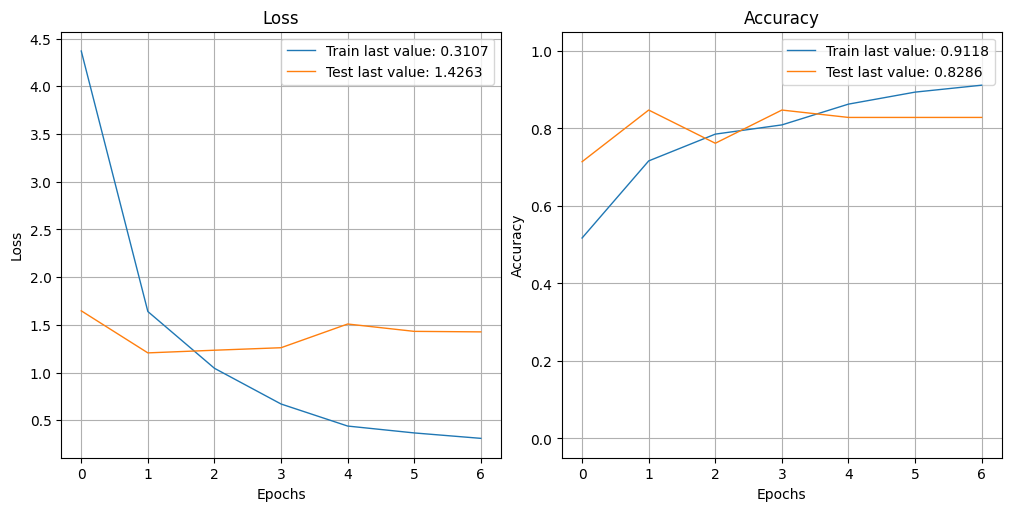

In [16]:
show_history(history1)

In [17]:
# Prédire les classes des données de validation
y_val_pred = model1.predict(X_val)

# Convertir les prédictions de probabilités en classes
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Calculer la matrice de confusion
conf_mat = metrics.confusion_matrix(np.argmax(y_val, axis=1), y_val_pred_classes)

# Afficher la matrice de confusion
print(conf_mat)

4/4 [==============================] - 1s 129ms/step
[[13  0  0  0  3  0  0]
 [ 0 10  3  1  1  0  0]
 [ 0  0 13  0  0  0  0]
 [ 0  0  0 11  1  2  1]
 [ 1  0  0  0 15  0  0]
 [ 0  1  2  0  0  9  0]
 [ 0  0  0  0  0  0 18]]


In [18]:
# Convertir les prédictions de probabilités en classes
y_val_pred_transform = np.argmax(y_val_pred, axis=1)

# Calculer la matrice de confusion
conf_mat = metrics.confusion_matrix(np.argmax(y_val, axis=1), y_val_pred_transform)

# Afficher la matrice de confusion
print(conf_mat)
print()

# Afficher le rapport de classification
print(metrics.classification_report(np.argmax(y_val, axis=1), y_val_pred_transform))

[[13  0  0  0  3  0  0]
 [ 0 10  3  1  1  0  0]
 [ 0  0 13  0  0  0  0]
 [ 0  0  0 11  1  2  1]
 [ 1  0  0  0 15  0  0]
 [ 0  1  2  0  0  9  0]
 [ 0  0  0  0  0  0 18]]

              precision    recall  f1-score   support

           0       0.93      0.81      0.87        16
           1       0.91      0.67      0.77        15
           2       0.72      1.00      0.84        13
           3       0.92      0.73      0.81        15
           4       0.75      0.94      0.83        16
           5       0.82      0.75      0.78        12
           6       0.95      1.00      0.97        18

    accuracy                           0.85       105
   macro avg       0.86      0.84      0.84       105
weighted avg       0.86      0.85      0.85       105



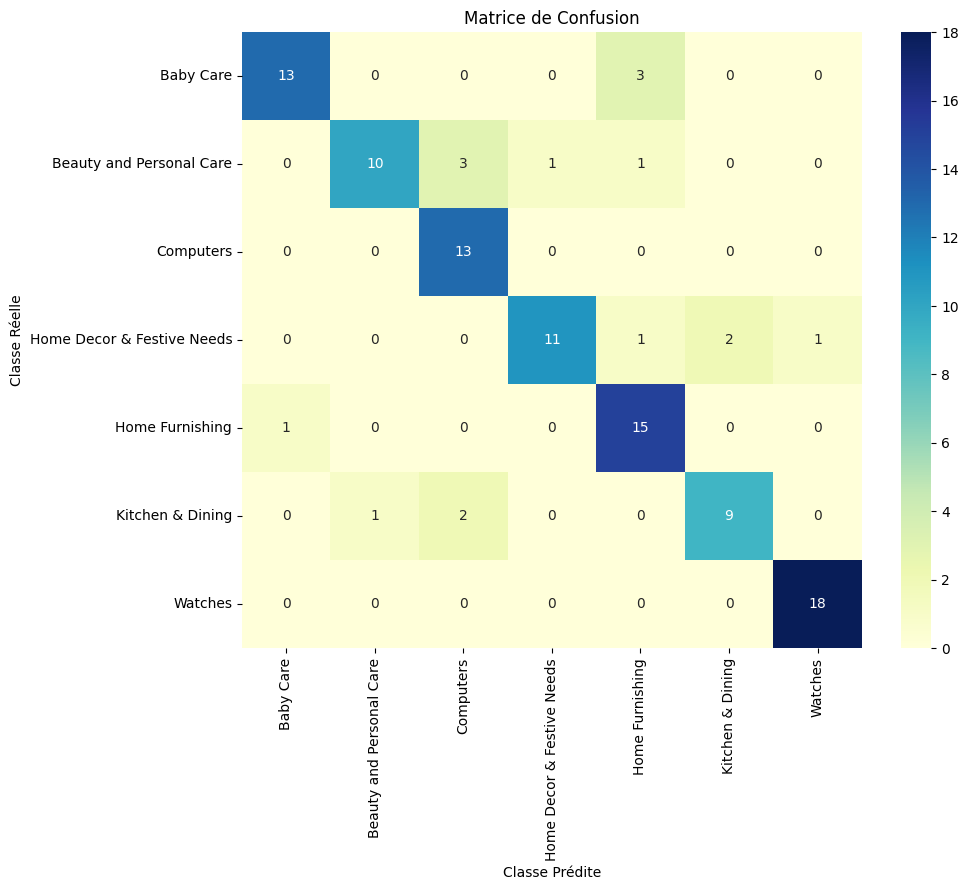

In [19]:
# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.title('Matrice de Confusion')
plt.show()

### Approche Data augmentation

In [20]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Préparation des données
labels = data['main_category']
data['image_data'] = data['image'].apply(lambda x: os.path.join(image_folder, x))
train_df, val_df = train_test_split(data, test_size=0.25, stratify=labels, random_state=42)

# Vérifier les fuites de données
train_ids = set(train_df['image_data'])
val_ids = set(val_df['image_data'])
assert not train_ids.intersection(val_ids), "Data leakage: Training and validation sets overlap!"
print("No data leakage detected between training and validation sets.")

# Définir la fonction dataset_fct pour créer les générateurs de données
def dataset_fct(dataframe, batch_size=32, image_size=(224, 224)):
    datagen = ImageDataGenerator(rescale=1./255)
    dataset = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=None,  # Les chemins complets sont déjà dans 'image_data'
        x_col='image_data',
        y_col='main_category',
        class_mode='categorical',
        batch_size=batch_size,
        target_size=image_size,
        color_mode='rgb',
        shuffle=True,
        seed=42,
        interpolation='bilinear',
        validate_filenames=True
    )
    return dataset

No data leakage detected between training and validation sets.


In [21]:
# Créer les générateurs de données pour l'entraînement et la validation
train_data = dataset_fct(train_df)
val_data = dataset_fct(val_df)

print(f"Found {train_data.samples} validated image filenames belonging to {len(train_data.class_indices)} classes for training.")
print(f"Found {val_data.samples} validated image filenames belonging to {len(val_data.class_indices)} classes for validation.")

Found 787 validated image filenames belonging to 7 classes.
Found 263 validated image filenames belonging to 7 classes.
Found 787 validated image filenames belonging to 7 classes for training.
Found 263 validated image filenames belonging to 7 classes for validation.


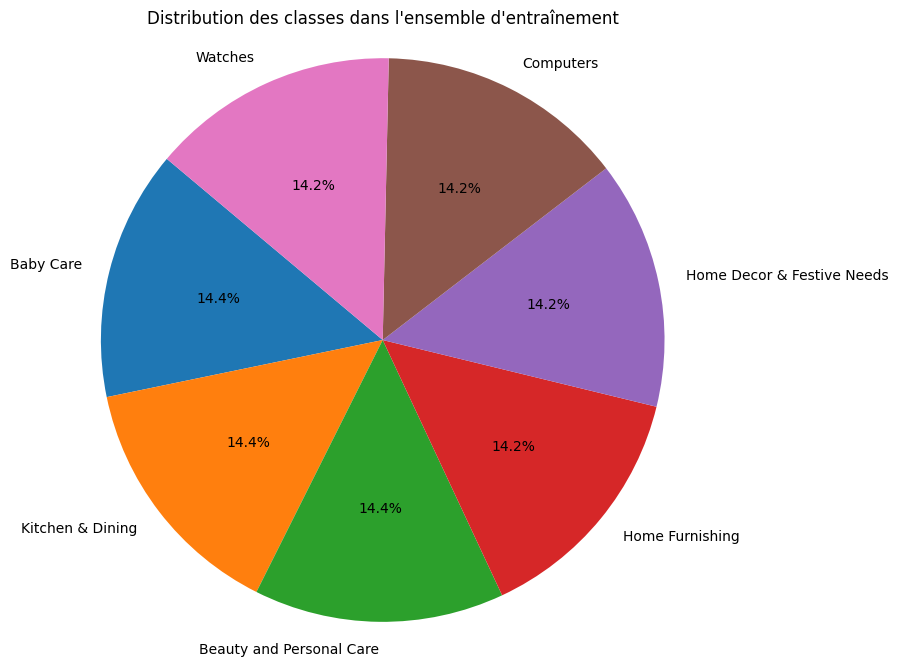

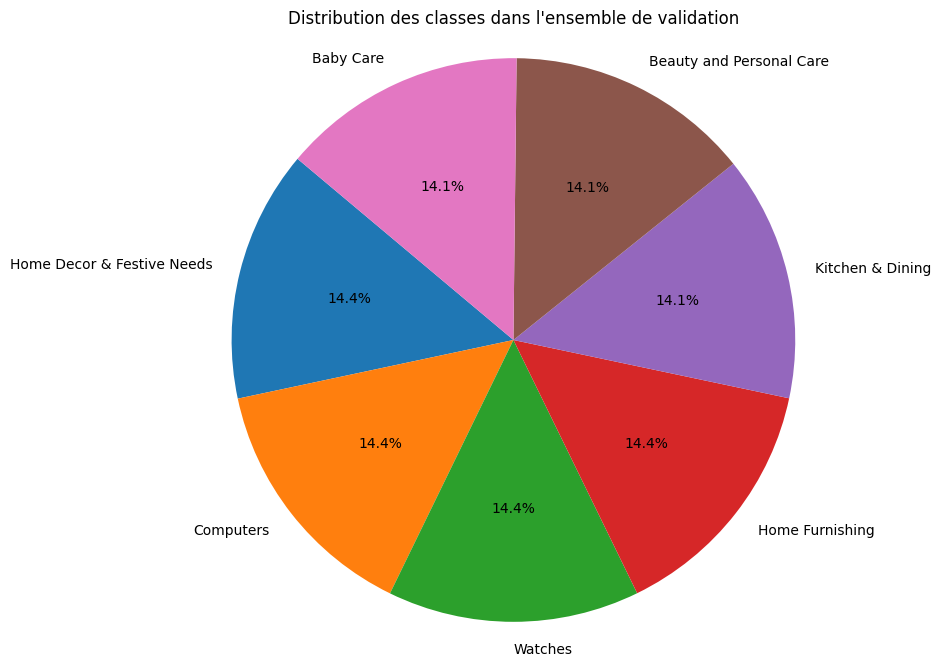

In [22]:
import matplotlib.pyplot as plt

# Distribution des classes dans l'ensemble d'entraînement
train_class_distribution = train_df['main_category'].value_counts()

# Distribution des classes dans l'ensemble de validation
val_class_distribution = val_df['main_category'].value_counts()

# Fonction pour créer un diagramme en camembert
def plot_pie_chart(distribution, title):
    plt.figure(figsize=(8, 8))
    plt.pie(distribution, labels=distribution.index, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')  # Assure que le cercle est dessiné correctement
    plt.show()

# Afficher les diagrammes en camembert
plot_pie_chart(train_class_distribution, "Distribution des classes dans l'ensemble d'entraînement")
plot_pie_chart(val_class_distribution, "Distribution des classes dans l'ensemble de validation")

In [23]:
# def resize_and_rescale(image, label):
#     image = tf.cast(image, tf.float32)
#     image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
#     image = (image / 255.0)
#     return image, label

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth, RandomContrast

def create_model_2():
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),  
        RandomHeight(0.1),  
        RandomWidth(0.1),  
        RandomContrast(0.1),  
    ])

    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base_model.layers[:12]: 
        layer.trainable = False

    model = Sequential([
        data_augmentation,
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.4), 
        Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dense(7, activation='softmax')
    ])

    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.00001), metrics=["accuracy"])
    model.summary()
    
    return model

In [25]:
# Create the model
with tf.device('/gpu:0'): 
    model2 = create_model_2()

# Callbacks
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
callbacks_list = [checkpoint, es, reduce_lr]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                        

In [26]:
# Train the model
with tf.device('/gpu:0'): 
    history2 = model2.fit(train_data,
                          validation_data=val_data,
                          epochs=200, 
                          callbacks=callbacks_list, 
                          verbose=1)

Epoch 1/200
25/25 [==============================] - ETA: 0s - loss: 12.9494 - accuracy: 0.1372
Epoch 1: val_loss improved from inf to 12.18027, saving model to .\model2_best_weights.h5
25/25 [==============================] - 201s 8s/step - loss: 12.9494 - accuracy: 0.1372 - val_loss: 12.1803 - val_accuracy: 0.1749 - lr: 1.0000e-05
Epoch 2/200
25/25 [==============================] - ETA: 0s - loss: 12.7140 - accuracy: 0.1766
Epoch 2: val_loss improved from 12.18027 to 12.15842, saving model to .\model2_best_weights.h5
25/25 [==============================] - 152s 6s/step - loss: 12.7140 - accuracy: 0.1766 - val_loss: 12.1584 - val_accuracy: 0.1597 - lr: 1.0000e-05
Epoch 3/200
25/25 [==============================] - ETA: 0s - loss: 12.7760 - accuracy: 0.1563
Epoch 3: val_loss did not improve from 12.15842
25/25 [==============================] - 157s 6s/step - loss: 12.7760 - accuracy: 0.1563 - val_loss: 12.1621 - val_accuracy: 0.1369 - lr: 1.0000e-05
Epoch 4/200
25/25 [=============

In [27]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_data, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_data, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

25/25 [==============================] - 19s 750ms/step - loss: 9.0762 - accuracy: 0.8628
Training Accuracy   : 0.8628

9/9 [==============================] - 5s 546ms/step - loss: 9.5329 - accuracy: 0.7262
Validation Accuracy :  0.7262


In [28]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_data, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(train_data, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.7643
Test Accuracy       :  0.9136


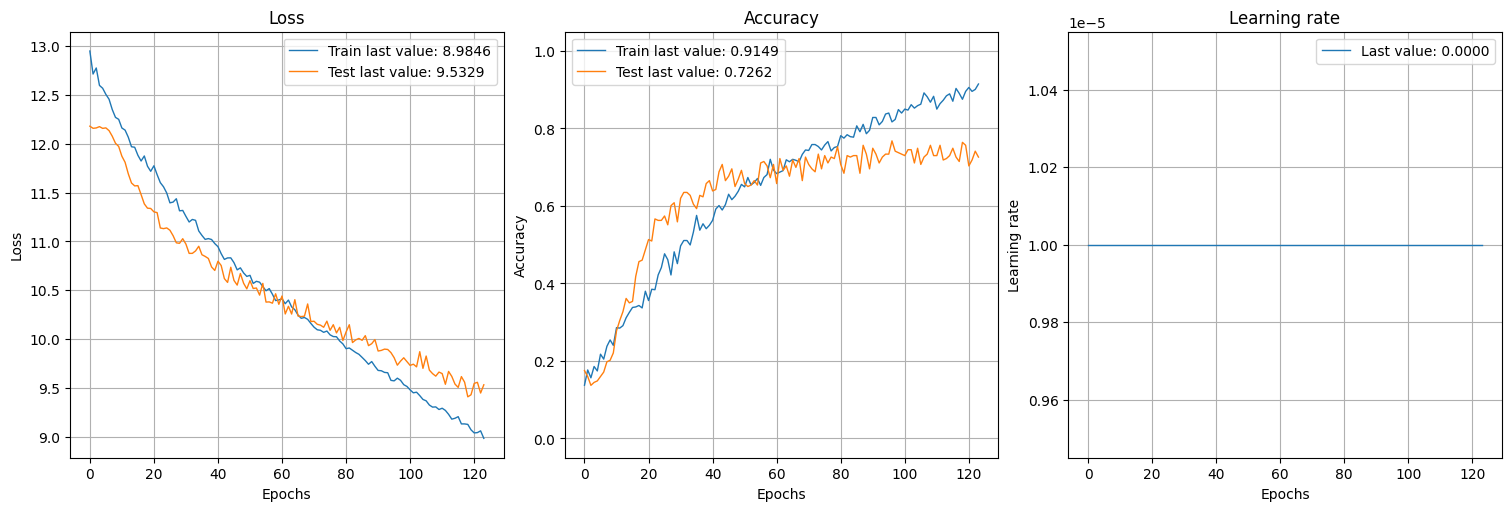

In [29]:
show_history(history2)

In [30]:
# Prédire les classes des données de validation
y_val_pred = model2.predict(X_val)

# Convertir les prédictions de probabilités en classes
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Calculer la matrice de confusion
conf_mat = metrics.confusion_matrix(np.argmax(y_val, axis=1), y_val_pred_classes)

# Afficher la matrice de confusion
print(conf_mat)

4/4 [==============================] - 1s 164ms/step
[[10  0  3  3  0  0  0]
 [ 0 12  0  3  0  0  0]
 [ 0  1 10  2  0  0  0]
 [ 0  0  0 15  0  0  0]
 [ 0  0  1 13  0  2  0]
 [ 0  2  0  3  0  7  0]
 [ 0  0  2  1  0  0 15]]


In [31]:
# Convertir les prédictions de probabilités en classes
y_val_pred_transform = np.argmax(y_val_pred, axis=1)

# Calculer la matrice de confusion
conf_mat = metrics.confusion_matrix(np.argmax(y_val, axis=1), y_val_pred_transform)

# Afficher la matrice de confusion
print(conf_mat)
print()

# Afficher le rapport de classification
print(metrics.classification_report(np.argmax(y_val, axis=1), y_val_pred_transform))

[[10  0  3  3  0  0  0]
 [ 0 12  0  3  0  0  0]
 [ 0  1 10  2  0  0  0]
 [ 0  0  0 15  0  0  0]
 [ 0  0  1 13  0  2  0]
 [ 0  2  0  3  0  7  0]
 [ 0  0  2  1  0  0 15]]

              precision    recall  f1-score   support

           0       1.00      0.62      0.77        16
           1       0.80      0.80      0.80        15
           2       0.62      0.77      0.69        13
           3       0.38      1.00      0.55        15
           4       0.00      0.00      0.00        16
           5       0.78      0.58      0.67        12
           6       1.00      0.83      0.91        18

    accuracy                           0.66       105
   macro avg       0.65      0.66      0.63       105
weighted avg       0.66      0.66      0.63       105



C:\Users\admin\miniconda3\envs\env_tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\miniconda3\envs\env_tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\miniconda3\envs\env_tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


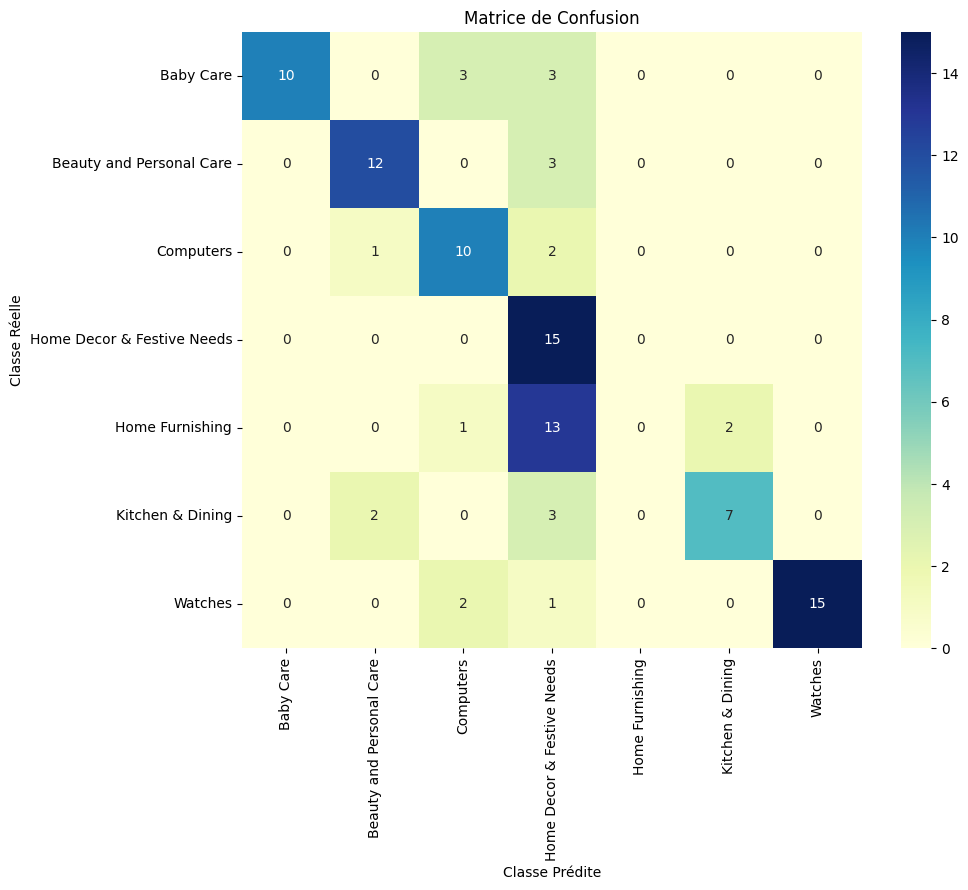

In [32]:
# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.title('Matrice de Confusion')
plt.show()

In [34]:
from sklearn.metrics import adjusted_rand_score
import numpy as np

# Prédire les classes des données de validation
y_val_pred = model2.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

# Calculer le score ARI
ari_score = adjusted_rand_score(y_val_true_classes, y_val_pred_classes)
print(f"Adjusted Rand Index (ARI) score : {ari_score:.4f}")

4/4 [==============================] - 1s 182ms/step
Adjusted Rand Index (ARI) score : 0.3946


Les résultats obtenus montrent que notre modèle de classification supervisée utilisant des techniques d’augmentation de données, a atteint des performances significatives.

	•	Précision sur les données d’entraînement : 86.28%
	•	Précision sur les données de validation : 72.62%
	•	Précision optimale sur les données de validation : 76.43%
	•	Précision sur les données de test : 91.36%
	•	Score Adjusted Rand Index (ARI) : 0.3946

Ces résultats indiquent que le modèle s’adapte bien aux données d’entraînement et de validation, avec une excellente performance sur l’ensemble de test. 

Les techniques d’augmentation de données ont contribué à améliorer la robustesse du modèle, réduisant potentiellement le sur-apprentissage.

Les matrices de confusion montrent une bonne performance globale, bien que certaines classes présentent encore des signes de confusion. 

Le score ARI de 0.3946 suggère une bonne cohérence entre les classes prédites et les classes réelles, confirmant la justesse globale de notre modèle de classification.